<a href="https://colab.research.google.com/github/dgalassi99/economics_projects/blob/main/effect_of_climate_change_on_GDP/Climate_Shocks_and_Economic_Growth_Evidence_from_2002_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Climate Shocks and Economic Growth: Evidence from 2002-2022

## Preparation

### Installing dependencies/libraries and importing key packages

In [ ]:
!pip install linearmodels
!pip install pyreadstat

In [ ]:
#import necessary packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
#panel data models
from linearmodels.panel import PanelOLS
#regular expressions (useful for parsing Stata .do files if needed)
import re
#if working with Stata .dta files
import pyreadstat
import os

### Connecting to google drive to access the files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Damiano
project_path = "/content/drive/My Drive/UNIGE/EECC/DATA_CODE"

#Ahmed
#project_path = "/content/drive/My Drive/EECC/DATA_CODE"

print("Files in project folder:", os.listdir(project_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files in project folder: ['Archigos.dta', 'AreaWeightedClimate.dta', 'climate_panel.dta', 'fips_to_cow.csv', 'makefigure1.do', 'makefigure2.do', 'maketable1.do', 'maketable2.do', 'maketable3.do', 'maketable4.do', 'maketable5.do', 'maketable6.do', 'maketable7.do', 'master.do', 'polity.dta', 'prio.csv', 'WDIinvest.csv', 'readme.pdf', 'GDL-Yearly-Average-Surface-Temperature-(ºC)-data.csv', 'GDL-Total-Yearly-Precipitation-(m)-data.csv', 'financial_economic_dataWB.xlsx', 'df_check_nan.gsheet', 'df_check_nan_GDPONLY.gsheet']


## Extension

### Data Management

In [ ]:
#defining the file to be retrieved
#Damiano
main_path = "/content/drive/My Drive/UNIGE/EECC/DATA_CODE/"
#Ahmed
#main_path = "/content/drive/My Drive/EECC/DATA_CODE/"
financial_df = pd.read_excel(main_path + "financial_economic_dataWB.xlsx")
precipitation_df = pd.read_csv(main_path + "GDL-Total-Yearly-Precipitation-(m)-data.csv")
temperature_df = pd.read_csv(main_path + "GDL-Yearly-Average-Surface-Temperature-(ºC)-data.csv")

In [ ]:
prec_cc = precipitation_df["ISO_Code"].unique()
temp_cc = temperature_df["ISO_Code"].unique()
econ_cc = financial_df["Country Code"].unique()

#matching countries in precipitation and temperature data
wth_cc = [cc for cc in prec_cc if cc in temp_cc]
print(f"Number of countries present in both precipitation and temperature data: {len(wth_cc)}")
#matching countries in weather and economic data
cc_final = [cc for cc in wth_cc if cc in econ_cc]
cc_final.extend([cc for cc in econ_cc if cc in wth_cc and cc not in cc_final])
print(f"Number of countries present in both weather and economic data: {len(cc_final)}")
print('This are the countries we can start with (now we will have to chekc for NaN or other issues)')

Number of countries present in both precipitation and temperature data: 196
Number of countries present in both weather and economic data: 192
This are the countries we can start with (now we will have to chekc for NaN or other issues)


In [ ]:
#dropping pakistan due to issues with the data
temperature_df = temperature_df[temperature_df['ISO_Code'] != 'PAK']
precipitation_df = precipitation_df[precipitation_df['ISO_Code'] != 'PAK']

In [ ]:
#rename columns of finacial_df
financial_df = financial_df.rename(
    columns={"Country Name": "country","Country Code": "cc","Series Name": "s_name"})
year_columns = [col for col in financial_df.columns if "[" in col and "YR" in col]
new_year_columns = {col: col[col.find("[YR") + 3:col.find("]")] for col in year_columns}
financial_df = financial_df.rename(columns=new_year_columns)
#drop Series Code
financial_df = financial_df.drop(columns=['Series Code'])
#financial_df.head()

In [ ]:
#renaming columsn for precipitation and temperature dfs
precipitation_df = precipitation_df.drop(columns=['Continent', 'Level', 'Region', 'GDLCODE'])
precipitation_df = precipitation_df.rename(columns={'Country': 'country', 'ISO_Code': 'cc'})
temperature_df = temperature_df.drop(columns=['Continent', 'Level', 'Region', 'GDLCODE'])
temperature_df = temperature_df.rename(columns={'Country': 'country', 'ISO_Code': 'cc'})

In [ ]:
#dropping forem the dfs all the countries we dont have full data fror (either we have only economic data or only weather data)
financial_df = financial_df[financial_df['cc'].isin(cc_final)]
precipitation_df = precipitation_df[precipitation_df['cc'].isin(cc_final)]
temperature_df = temperature_df[temperature_df['cc'].isin(cc_final)]

In [ ]:
#check if the unique country codes are the same in all three DataFrames
all(np.isin(financial_df.cc.unique(), precipitation_df.cc.unique())) and \
all(np.isin(financial_df.cc.unique(), temperature_df.cc.unique())) and \
all(np.isin(precipitation_df.cc.unique(), temperature_df.cc.unique()))

False

In [ ]:
#dropping years from 1974 to 1989 from financial_df
columns_to_drop = [str(year) for year in range(1974, 2002)] + ['2023']  # Add '2023' to the list
financial_df = financial_df.drop(columns=columns_to_drop, errors='ignore')

Great we can now proceed with merging the precipitation and weather data into teh main financial_df and name it as df



In [ ]:
#melt the dfs (wide -> long)
temperature_long = temperature_df.melt(id_vars=['country', 'cc'], var_name='year', value_name='temp')
precipitation_long = precipitation_df.melt(id_vars=['country', 'cc'], var_name='year', value_name='prec')
financial_long = financial_df.melt(id_vars=['country', 'cc', 's_name'], var_name='year', value_name='s_value')
#merge financial, temperature, and precipitation data
merged_df = pd.merge(financial_long, temperature_long, on=['country', 'cc', 'year'], how='left')
merged_df = pd.merge(merged_df, precipitation_long, on=['country', 'cc', 'year'], how='left')

merged_df['s_value'] = pd.to_numeric(merged_df['s_value'], errors='coerce')
# Display result
#merged_df.head()

This step is needed as we need to create a dummy for poor and rich countries to check for fixed effects :)

In [ ]:
#create a df with s_value == GDP x capita only
gdp_per_capita_df = merged_df[merged_df['s_name'] == 'GDP per capita (current US$)']
#groupby cc and get the years where s_value is not NaN
years_not_nan = gdp_per_capita_df[gdp_per_capita_df['s_value'].notna()].groupby('cc')['year'].apply(list).reset_index()
#create a column which displays the first year not NaN
years_not_nan['first_year_not_nan'] = years_not_nan['year'].apply(min)
#check if all coutnries have teh 2002 gdp value by display True or False
all_2002 = (years_not_nan['first_year_not_nan'] == '2002').all()
print(all_2002)

False


In [ ]:
cc_not_2002 = years_not_nan[years_not_nan['first_year_not_nan'] != '2002']['cc'].tolist()
print(f"Country codes with first non-NaN year not '2002': {cc_not_2002}")

Country codes with first non-NaN year not '2002': ['SSD']


Inspecting visually the distribution of gdp x capita for each cc

In [ ]:
first_gdp_df = pd.merge(gdp_per_capita_df, years_not_nan[['cc', 'first_year_not_nan']], on='cc', how='left')
first_gdp_df = first_gdp_df[first_gdp_df['year'] == first_gdp_df['first_year_not_nan']]

# Display info (remove commment symbol to printi it)
#first_gdp_df.info()

Now we create categories to flag if:
- a country is poor = 1 if gdp x capita first year is below median, = 0 otherwise
- divide teh countries into subcategories (african, europe ...)

In [ ]:
#calculate the median GDP per capita
median_gdp = first_gdp_df['s_value'].median()
#what happens if i test different percentiles
tfth_percentile_gdp = first_gdp_df['s_value'].quantile(0.25)
sfth_percentile_gdp = first_gdp_df['s_value'].quantile(0.75)

#create the 'poor' dummy variable
first_gdp_df['poor'] = (first_gdp_df['s_value'] < median_gdp).astype(int)

# Create a dictionary mapping country codes to 'poor' values
cc_poor_mapping = dict(zip(first_gdp_df['cc'], first_gdp_df['poor']))
# Add 'poor' column to merged_df using the mapping
merged_df['poor'] = merged_df['cc'].map(cc_poor_mapping).fillna(0).astype(int)

poor_countries_cc = first_gdp_df[first_gdp_df['poor'] == 1]['cc'].tolist()
rich_countries_cc = first_gdp_df[first_gdp_df['poor'] == 0]['cc'].tolist()
#printing the list of poor and rich countries to double check
print("Country codes where poor = 1:", poor_countries_cc)
print("Country codes where poor = 0:", rich_countries_cc)

#rechecking if it is balanced, should be 50%
print(f'The % of conutries being assigned to poor are {round(merged_df.poor[merged_df.poor == 1].count()/merged_df.shape[0]*100,2)}%')

Country codes where poor = 1: ['SSD', 'AFG', 'ALB', 'DZA', 'AGO', 'ARM', 'AZE', 'BGD', 'BLR', 'BEN', 'BTN', 'BOL', 'BIH', 'BFA', 'BDI', 'CPV', 'KHM', 'CMR', 'CAF', 'TCD', 'CHN', 'COM', 'COD', 'COG', 'CIV', 'DJI', 'EGY', 'ERI', 'SWZ', 'ETH', 'GMB', 'GEO', 'GHA', 'GTM', 'GIN', 'GNB', 'GUY', 'HTI', 'HND', 'IND', 'IDN', 'IRN', 'IRQ', 'JOR', 'KAZ', 'KEN', 'KIR', 'KGZ', 'LAO', 'LSO', 'LBR', 'MDG', 'MWI', 'MLI', 'MRT', 'MDA', 'MNG', 'MAR', 'MOZ', 'MMR', 'NAM', 'NPL', 'NIC', 'NER', 'NGA', 'MKD', 'PAK', 'PNG', 'PRY', 'PHL', 'RWA', 'WSM', 'STP', 'SEN', 'SLE', 'SLB', 'SOM', 'LKA', 'SDN', 'SYR', 'TJK', 'TZA', 'TLS', 'TGO', 'TON', 'TKM', 'UGA', 'UKR', 'UZB', 'VUT', 'VNM', 'PSE', 'YEM', 'ZMB', 'ZWE']
Country codes where poor = 0: ['AND', 'ATG', 'ARG', 'AUS', 'AUT', 'BHS', 'BHR', 'BRB', 'BEL', 'BLZ', 'BWA', 'BRA', 'BRN', 'BGR', 'CAN', 'CHL', 'COL', 'CRI', 'HRV', 'CUB', 'CYP', 'CZE', 'DNK', 'DMA', 'DOM', 'ECU', 'SLV', 'GNQ', 'EST', 'FJI', 'FIN', 'FRA', 'PYF', 'GAB', 'DEU', 'GRC', 'GRL', 'GRD', 'HUN', 

In [ ]:
#dicstionary with regions and relative cc codes
regions = {
    "MENA": ["DZA", "BHR", "EGY", "IRN", "IRQ", "ISR", "JOR", "KWT", "LBN", "LBY", "MAR", "OMN", "PSE", "QAT", "SAU", "SYR", "TUN", "TUR", "ARE", "YEM"],
    "SSA": ["AGO", "BEN", "BWA", "BFA", "BDI", "CMR", "CPV", "CAF", "TCD", "COM", "COD", "COG", "DJI", "GNQ", "ERI", "SWZ", "ETH", "GAB", "GMB", "GHA", "GIN", "GNB", "CIV", "KEN", "LSO", "LBR", "MDG", "MWI", "MLI", "MRT", "MUS", "MOZ", "NAM", "NER", "NGA", "RWA", "STP", "SEN", "SYC", "SLE", "SOM", "ZAF", "SSD", "SDN", "TZA", "TGO", "UGA", "ZMB", "ZWE"],
    "LATAM": ["ARG", "BHS", "BRB", "BLZ", "BOL", "BRA", "CHL", "COL", "CRI", "CUB", "DMA", "DOM", "ECU", "SLV", "GRD", "GTM", "GUY", "HTI", "HND", "JAM", "MEX", "NIC", "PAN", "PRY", "PER", "KNA", "LCA", "VCT", "SUR", "TTO", "URY", "VEN"],
    "WEO": ["AND", "AUS", "AUT", "BEL", "CAN", "CYP", "DNK", "FIN", "FRA", "DEU", "GRC", "ISL", "IRL", "ITA", "LUX", "MLT", "NLD", "NZL", "NOR", "PRT", "SMR", "ESP", "SWE", "CHE", "GBR", "USA"],
    "EECA": ["ALB", "ARM", "AZE", "BLR", "BIH", "BGR", "HRV", "CZE", "EST", "GEO", "HUN", "KAZ", "XKX", "KGZ", "LVA", "LTU", "MDA", "MNE", "MKD", "POL", "ROU", "RUS", "SRB", "SVK", "SVN", "TJK", "TKM", "UKR", "UZB"],
    "API": ["AFG", "BGD", "BTN", "BRN", "KHM", "CHN", "FJI", "IND", "IDN", "JPN", "KIR", "LAO", "MYS", "MDV", "MNG", "MMR", "NRU", "NPL", "PRK", "PLW", "PNG", "PHL", "WSM", "SGP", "SLB", "KOR", "LKA", "TWN", "THA", "TLS", "TON", "TUV", "VUT", "VNM"]
}
#now we need to insert this into the df


In [ ]:
#create a reverse mapping from country code to region
cc_to_region = {}
for region, countries in regions.items():
    for country in countries:
        cc_to_region[country] = region

#add 'region' column to merged_df using the mapping
merged_df['region'] = merged_df['cc'].map(cc_to_region)

#display the updated merged_df
#merged_df.head()

In [ ]:
#check
merged_df[merged_df['region']=='API']['cc'].unique().tolist() == regions['API']

False

In [ ]:
#convert to wide format
df_wide = merged_df.pivot(index=["country", "cc", "year", "temp", "prec", "poor", "region"],
                   columns="s_name",
                   values="s_value").reset_index()
#remove the column index name
df_wide.columns.name = None
#rename columns with short names
rename_dict = {
    "Inflation, consumer prices (annual %)": "inflation",
    "GDP per capita (current US$)": "gdp_pc",
    "GDP per capita growth (annual %)": "gdp_pc_growth",
    "GDP growth (annual %)": "gdp_growth",
    "GDP (current US$)": "gdp",
    "GDP per person employed (constant 2021 PPP $)": "gdp_emp",
    "Gross fixed capital formation (% of GDP)": "gfcf",
    "Insurance and financial services (% of service exports, BoP)": "insurance_exports",
    "Foreign direct investment, net inflows (% of GDP)": "fdi",
    "Domestic credit to private sector (% of GDP)": "credit_private",
    "Market capitalization of listed domestic companies (% of GDP)": "market_cap"
}

#apply the new names to the columns
df_wide = df_wide.rename(columns=rename_dict)
#df_wide.head()


In [ ]:
#before proceeding let's just covert rain into 100mm of water
df_wide['prec'] = df_wide['prec']*10

### Main Stats

In [ ]:
df_wide.describe()

,temp,prec,poor,credit_private,fdi,gdp,gdp_growth,gdp_pc,gdp_pc_growth,gdp_emp,gfcf,inflation,insurance_exports,market_cap
count,3969.000000,3969.000000,4032.000000,3306.000000,3603.000000,3.950000e+03,3916.000000,3954.000000,3916.000000,3579.000000,3305.000000,3605.000000,3228.000000,1456.000000
mean,19.136656,0.395180,0.494792,50.301093,6.739784,3.661685e+11,3.486128,14845.006171,2.063886,49586.130271,22.948767,6.309717,5.367843,57.766862
std,8.077371,0.275065,0.500035,43.271119,49.701806,1.563742e+12,5.539083,24598.207504,5.438614,46319.649407,7.747747,17.088743,8.929653,56.821736
min,-19.490000,0.000000,0.000000,0.001297,-1303.108267,7.474389e+07,-50.338515,109.593814,-49.127857,1848.456680,1.225171,-16.859691,-0.444389,0.009202
25%,12.050000,0.210000,0.000000,17.682018,1.084559,6.239855e+09,1.445864,1422.047178,0.053848,13489.841433,18.578775,1.625907,1.079840,20.773914
50%,22.400000,0.340000,0.000000,37.764215,2.710307,2.452731e+10,3.726800,4675.473668,2.193584,36290.726600,22.138676,3.528394,2.451938,40.062370
75%,25.830000,0.520000,1.000000,68.836800,5.515649,1.728137e+11,6.024658,17719.970719,4.443129,70801.274159,26.256018,7.189384,5.682374,77.409767
max,29.610000,1.650000,1.000000,304.575113,1282.607229,2.600689e+13,86.826748,226052.001905,91.781370,316456.423797,78.000917,557.201817,96.323110,587.202889


In [ ]:
#creating a box plot to check the outliers in gdp growth
import plotly.express as px

fig = px.box(df_wide, y='gdp_growth', title='Box Plot of GDP Growth')
fig.show()


In [ ]:
#there are some outliers let's checkl to which country-year combination they belong
df_wide[df_wide['gdp_growth'] > 30]

,country,cc,year,temp,prec,poor,region,credit_private,fdi,gdp,gdp_growth,gdp_pc,gdp_pc_growth,gdp_emp,gfcf,inflation,insurance_exports,market_cap
214,Azerbaijan,AZE,2006,11.96,0.19,1,EECA,NaN,21.380140,2.098193e+10,34.500000,2472.957257,33.030488,28789.417024,29.700953,8.328925,1.562408,NaN
695,Chad,TCD,2004,27.92,0.17,1,SSA,3.133763,NaN,4.422856e+09,33.629372,445.850767,27.807315,5073.692356,22.740358,-5.355400,NaN,NaN
1115,Equatorial Guinea,GNQ,2004,23.89,1.02,0,SSA,2.722154,NaN,4.410764e+09,37.998727,4901.301274,30.016298,86021.546759,NaN,4.219688,NaN,NaN
1572,Guyana,GUY,2020,25.90,0.72,1,LATAM,39.175718,23.659693,5.471257e+09,43.479652,6775.709391,43.512346,63555.018877,NaN,0.993337,13.502058,NaN
1574,Guyana,GUY,2022,25.44,0.92,1,LATAM,20.187566,2.990205,1.471839e+10,63.334587,17913.491015,62.111024,118842.046863,NaN,6.115056,39.999786,NaN
1724,Iraq,IRQ,2004,23.34,0.09,1,MENA,1.266927,NaN,3.663367e+10,53.385547,1328.371576,49.073853,46770.552103,5.368250,26.961907,NaN,NaN
2152,Libya,LBY,2012,22.18,0.01,0,MENA,9.338085,2.711233,9.254094e+10,86.826748,14975.890280,91.781370,75542.285858,15.936164,6.059804,21.419185,NaN
2157,Libya,LBY,2017,21.56,0.01,0,MENA,14.789628,0.163794,6.715745e+10,32.491802,9965.832367,30.395061,55587.671359,16.183148,25.803618,41.495327,NaN
3588,Timor-Leste,TLS,2020,25.10,0.53,1,API,13.424647,-32.955232,2.162619e+09,31.725742,1630.869354,29.231596,16099.141838,13.701127,0.495499,-0.444389,NaN


In [ ]:
df_wide[df_wide['gdp_growth'] <-20]

,country,cc,year,temp,prec,poor,region,credit_private,fdi,gdp,gdp_growth,gdp_pc,gdp_pc_growth,gdp_emp,gfcf,inflation,insurance_exports,market_cap
19,Afghanistan,AFG,2021,11.180,0.10,1,API,NaN,0.215925,1.426000e+10,-20.738839,356.496214,-22.584482,10611.840292,12.986704,NaN,NaN,NaN
249,"Bahamas, The",BHS,2020,25.980,0.37,0,LATAM,NaN,4.364241,9.958200e+09,-21.423463,25155.672543,-21.659274,52543.438344,23.017212,0.038521,NaN,NaN
606,Cabo Verde,CPV,2020,23.450,0.07,1,SSA,68.456032,3.712185,1.821566e+09,-20.805276,3539.226620,-20.893752,21453.992529,NaN,0.605796,1.568847,NaN
683,Central African Republic,CAF,2013,25.820,0.40,1,SSA,13.576826,NaN,1.691544e+09,-36.391977,364.366963,-36.824547,2738.662262,6.349849,6.988793,NaN,NaN
1723,Iraq,IRQ,2003,23.380,0.09,1,MENA,NaN,NaN,2.192157e+10,-36.656780,817.887862,-38.538218,31538.543373,10.650954,33.616211,NaN,NaN
2097,Lebanon,LBN,2020,17.360,0.22,0,MENA,NaN,5.067130,3.171213e+10,-21.399900,5561.191670,-20.129098,44268.490517,8.098176,84.864333,7.633512,21.136298
2122,Liberia,LBR,2003,25.130,0.87,1,SSA,2.558169,23.125551,7.480000e+08,-30.145133,239.779557,-30.699353,3050.969833,NaN,10.330288,NaN,NaN
2151,Libya,LBY,2011,21.670,0.01,0,MENA,14.181919,0.271958,4.816926e+10,-50.338515,7593.839153,-49.127857,39234.553479,17.394453,15.518482,NaN,NaN
2154,Libya,LBY,2014,22.690,0.01,0,MENA,19.318719,0.134211,5.737236e+10,-23.042806,8926.420746,-24.511054,45511.661795,23.202517,2.432941,41.161616,NaN
2160,Libya,LBY,2020,22.400,0.01,0,MENA,21.833739,-1.039820,4.685429e+10,-29.455297,6650.338106,-30.400172,36185.092580,9.449828,1.447037,30.762411,NaN


These numbers seem fair as most of these extreme gdp change year to year are for very poor countries which can experience political, economic and fiscal instability

### Creating FEs

1. Country Fixed Effects

- How?
create a set of dummy variables, where each dummy variable corresponds to a specific country in your dataset. For each observation (country-year), the dummy variable for that country would take the value 1, and all other country dummy variables would take the value 0 . If you have N countries, you will create N-1 dummy variables to avoid multicollinearity
assign a unique identifier for each country
- Why?
create a set of dummy variables, where each dummy variable corresponds to a specific country in your dataset. For each observation (country-year), the dummy variable for that country would take the value 1, and all other country dummy variables would take the value 0.

2. Region x Year FEs
- How?
define your regions. Dell et al. (2012) use regions such as Middle East/North Africa, sub-Saharan Africa, Latin America and Caribbean, Western Europe and offshoots, Eastern Europe and Central Asia, and Asia and Pacific Islands. Once regions are defined, you would create a set of interaction dummy variables. Each dummy would represent a specific region in a specific year. For example, you would have a dummy for "Sub-Saharan Africa in 1990," which takes the value 1 for all countries in Sub-Saharan Africa in 1990, and 0 otherwise..
- Why?
 to control for common shocks or trends that affect all countries within a specific geographic region in a given year. Countries in the same region might experience similar external events like regional economic crises, political instability affecting the whole region, or regional environmental phenomena (e.g., a hurricane season affecting the Caribbean) that could simultaneously impact their economic growth. These fixed effects help to isolate the effects of country-specific weather fluctuations from these broader regional time-varying factors
3. Poor x Year FEs
- How?
 define a country as "poor" if its per capita GDP in the first year it enters the dataset is below the median for all countries in that first year. You would then create a dummy variable indicating whether a country is "poor" based on this definition. Next, you would create interaction dummy variables between this "poor" country dummy and each year in your dataset. For example, the "poor x 1985" dummy would take the value 1 for all poor countries in 1985, and 0 otherwise.
- Why?
d to account for common shocks or trends that disproportionately affect poor countries as a group in a given year, beyond the effects captured by region x year fixed effects. Poor countries might be more susceptible to certain global economic trends (e.g., commodity price volatility, global financial crises) or might be subject to specific international policies or aid flows that affect them differently than wealthier nations. These fixed effects ensure that the estimated temperature effects in poor countries are not simply reflecting these broader trends specific to their economic status.

In [ ]:
#rename the df in a simpler way
df = df_wide.copy()
#df

In [ ]:
#contry fixed effects
cfe_formula = "C(country)"  # Creates country dummies internally
#Region × Year fixed effects (handled in regression)
df["region_year"] = df["region"] + "_" + df["year"].astype(str)
ryfe_formula = "C(region_year)"
# Create Poor × Year Fes
df["poor_year"] = df["poor"].astype(str) + "_" + df["year"].astype(str)
pyfe_formula = "C(poor_year)"

### Regression - Focus on GDP Growth

#### Data Cleaning and Wrangling

In [ ]:
initial_dataset_size = df.shape[0]
print("Initial dataset size:", initial_dataset_size)

Initial dataset size: 4032


In [ ]:
#first let's eliminate the column we do not need (we only keep gdp_growth as outcome var)
df = df[['country', 'cc', 'year', 'temp', 'prec', 'poor', 'region','gdp', 'gdp_growth',
       'region_year', 'poor_year']]
#let's see how many missing data points we have
df.isna().sum()

,0
country,0
cc,0
year,0
temp,63
prec,63
poor,0
region,210
gdp,82
gdp_growth,116
region_year,210


In [ ]:
#checking which rows have region = NaN
df[df['region'].isna()].country.unique()

array(['Antigua and Barbuda', 'French Polynesia', 'Gibraltar',
       'Greenland', 'Isle of Man', 'Liechtenstein',
       'Micronesia, Fed. Sts.', 'Monaco', 'Pakistan',
       'Turks and Caicos Islands'], dtype=object)

In [ ]:
#these coutrnies are of very little influence for the analysis so let's drop them
countries_2_elimiante = ['Antigua and Barbuda', 'French Polynesia', 'Gibraltar',
       'Greenland', 'Isle of Man', 'Liechtenstein',
       'Micronesia, Fed. Sts.', 'Monaco', 'Pakistan',
       'Turks and Caicos Islands']
df = df[~df['country'].isin(countries_2_elimiante)]
df.isna().sum()

,0
country,0
cc,0
year,0
temp,21
prec,21
poor,0
region,0
gdp,59
gdp_growth,70
region_year,0


In [ ]:
#ok we still have some missing values
#let's see which data have missing values on gdp
df[df['gdp_growth'].isna()][:15]

,country,cc,year,temp,prec,poor,region,gdp,gdp_growth,region_year,poor_year
987,Djibouti,DJI,2002,28.46,0.10,1,SSA,5.911220e+08,NaN,SSA_2002,1_2002
988,Djibouti,DJI,2003,28.44,0.08,1,SSA,6.220447e+08,NaN,SSA_2003,1_2003
989,Djibouti,DJI,2004,28.60,0.09,1,SSA,6.660721e+08,NaN,SSA_2004,1_2004
990,Djibouti,DJI,2005,28.60,0.08,1,SSA,7.086332e+08,NaN,SSA_2005,1_2005
991,Djibouti,DJI,2006,28.34,0.13,1,SSA,7.688737e+08,NaN,SSA_2006,1_2006
992,Djibouti,DJI,2007,28.46,0.07,1,SSA,8.479189e+08,NaN,SSA_2007,1_2007
993,Djibouti,DJI,2008,28.06,0.05,1,SSA,9.991053e+08,NaN,SSA_2008,1_2008
994,Djibouti,DJI,2009,28.38,0.05,1,SSA,1.049111e+09,NaN,SSA_2009,1_2009
995,Djibouti,DJI,2010,28.32,0.09,1,SSA,1.128612e+09,NaN,SSA_2010,1_2010
996,Djibouti,DJI,2011,28.07,0.07,1,SSA,1.239145e+09,NaN,SSA_2011,1_2011


In [ ]:
df = df.dropna(subset=['gdp_growth'])
df.isna().sum()

,0
country,0
cc,0
year,0
temp,0
prec,0
poor,0
region,0
gdp,2
gdp_growth,0
region_year,0


In [ ]:
#only 2 missing dta point left
df = df.dropna()
df.isna().sum()

,0
country,0
cc,0
year,0
temp,0
prec,0
poor,0
region,0
gdp,0
gdp_growth,0
region_year,0


In [ ]:
final_dataset_size = df.shape[0]
eliminated_rows = initial_dataset_size - final_dataset_size

print("Number of rows eliminated:", eliminated_rows)
print("The % of data that has been eliminatd is:",round(eliminated_rows/initial_dataset_size*100,2))


Number of rows eliminated: 282
The % of data that has been eliminatd is: 6.99


In [ ]:
#how many coutrnies we do have
df.country.nunique()

181

#### Summary Stats

In [ ]:
df.describe()

,temp,prec,poor,gdp,gdp_growth
count,3750.000000,3750.000000,3750.000000,3.750000e+03,3750.000000
mean,19.267735,0.395125,0.515467,3.841803e+11,3.536781
std,7.631790,0.273947,0.499827,1.602811e+12,5.545695
min,-0.599000,0.000000,0.000000,7.474389e+07,-50.338515
25%,12.082500,0.210000,0.000000,7.744026e+09,1.484069
50%,22.395000,0.340000,1.000000,2.757013e+10,3.756505
75%,25.787500,0.520000,1.000000,1.856349e+11,6.060677
max,29.610000,1.650000,1.000000,2.600689e+13,86.826748


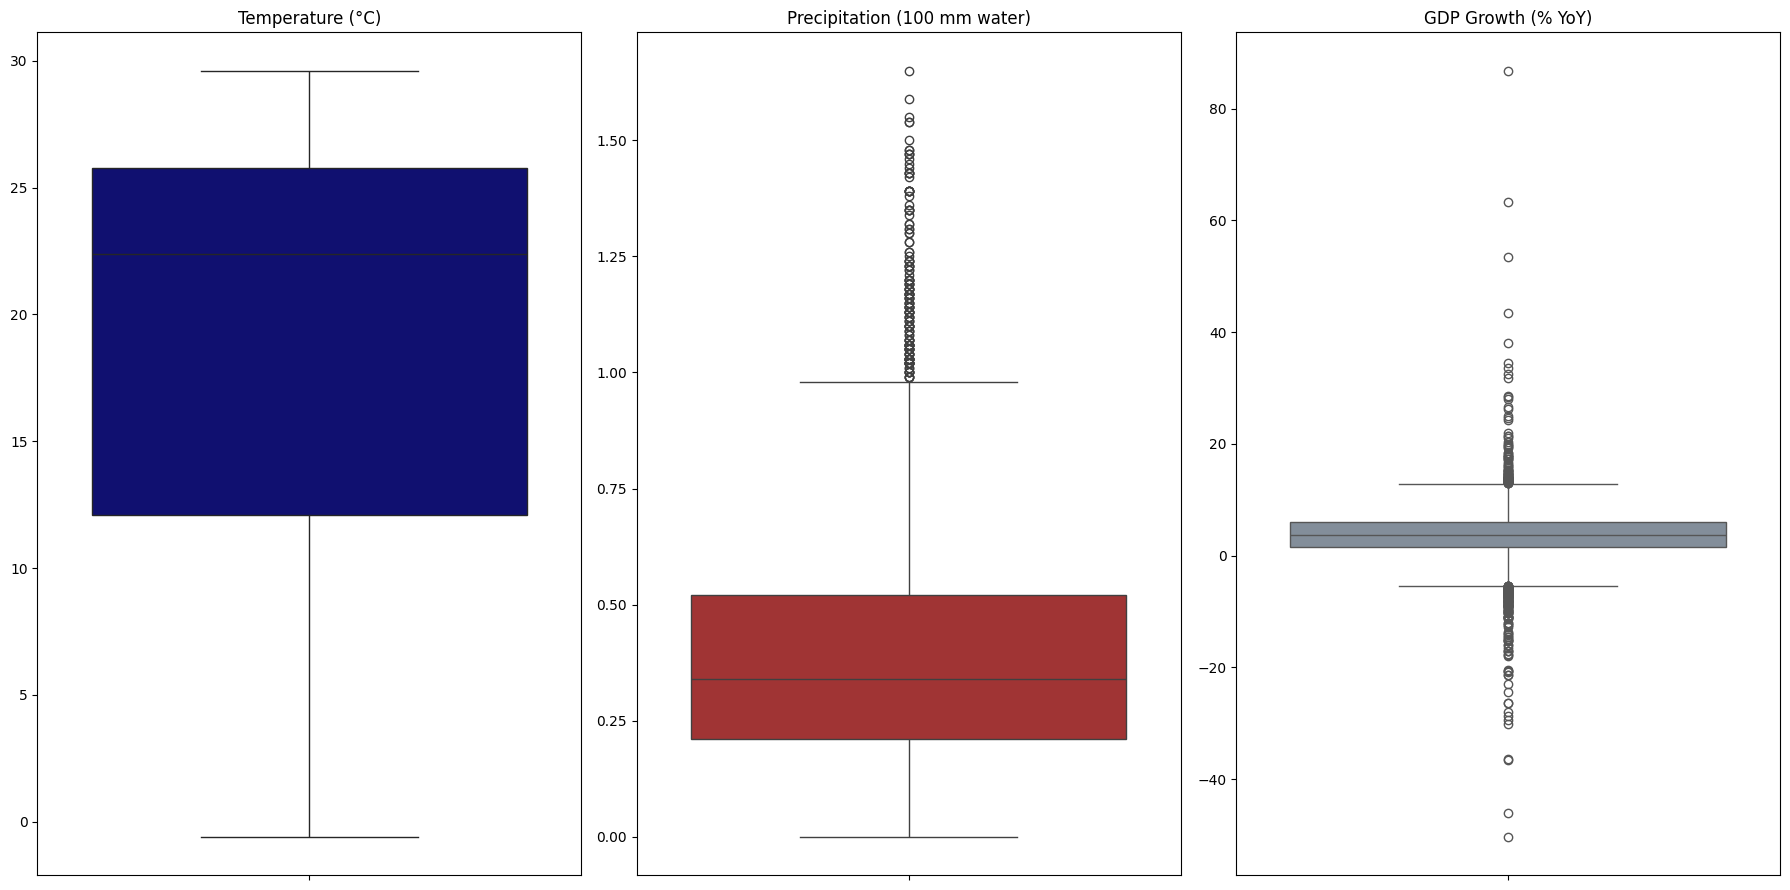

In [ ]:
#set up the grid
fig, axes = plt.subplots(1, 3, figsize=(18, 9))
#boxplots for key variables
sns.boxplot(y=df['temp'], ax=axes[0], color='navy')
axes[0].set_title('Temperature (°C)')
axes[0].set_ylabel('')
sns.boxplot(y=df['prec'], ax=axes[1], color='firebrick')
axes[1].set_title('Precipitation (100 mm water)')
axes[1].set_ylabel('')
sns.boxplot(y=df['gdp_growth'], ax=axes[2], color='#7f8e9e')
axes[2].set_title('GDP Growth (% YoY)')
axes[2].set_ylabel('')

plt.tight_layout()
plt.show()


In [ ]:
df.region.unique()

array(['API', 'EECA', 'MENA', 'WEO', 'SSA', 'LATAM'], dtype=object)

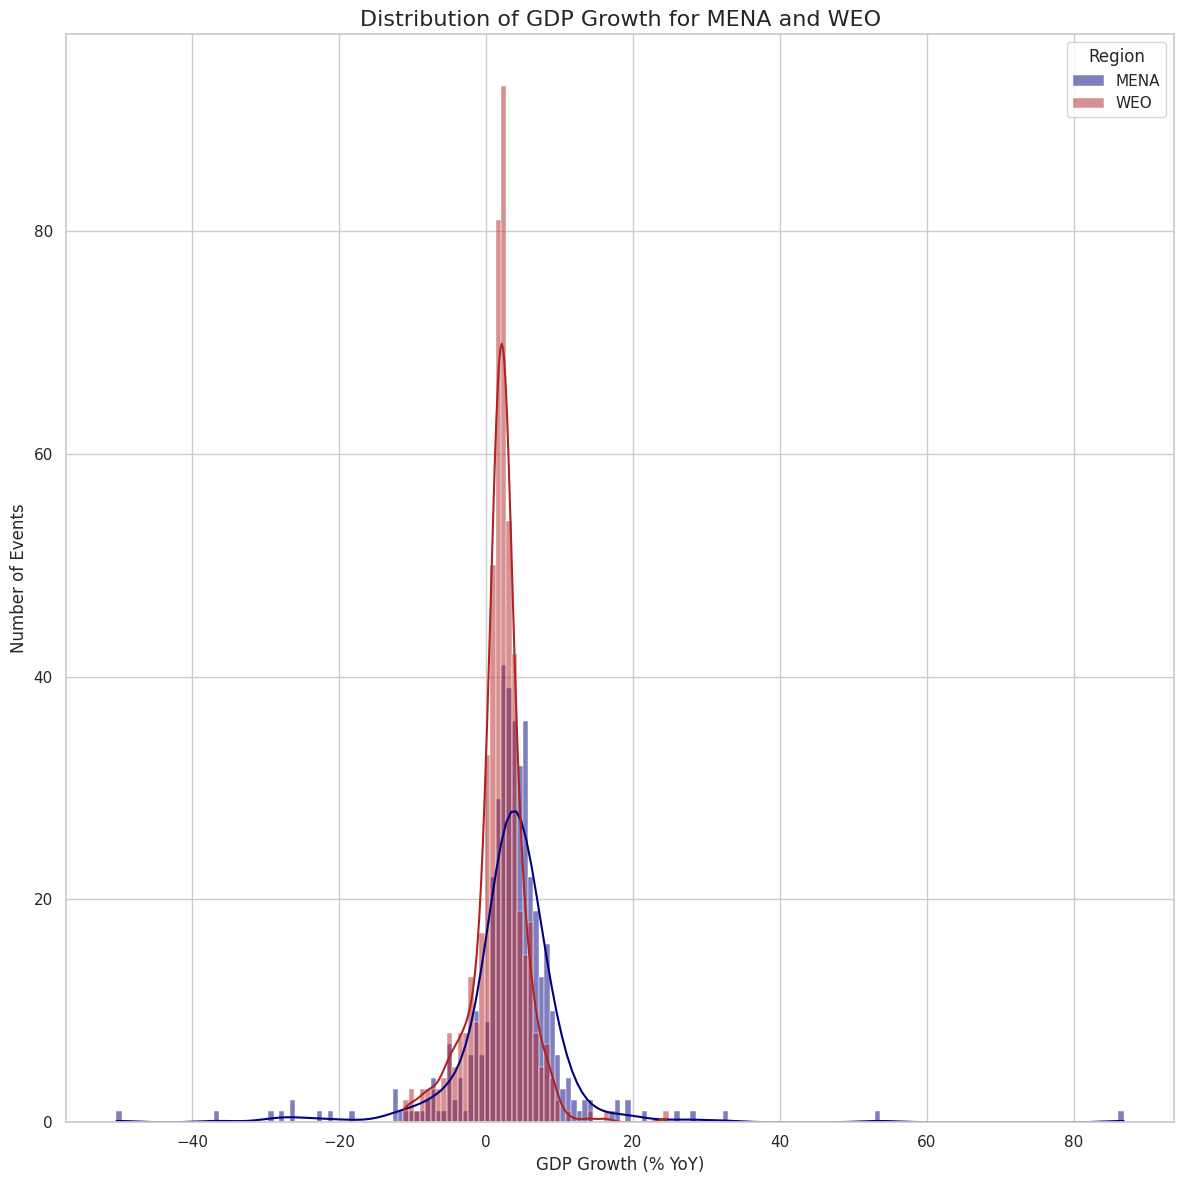

In [ ]:
#distribution of gdp growth for MENA and WEO

#filter data for MENA and WEO regions
mena_data = df[df['region'] == 'MENA']['gdp_growth']
weo_data = df[df['region'] == 'WEO']['gdp_growth']


sns.set(style='whitegrid')
combined_data = pd.concat([mena_data, weo_data])
bin_edges = np.histogram_bin_edges(combined_data, bins='auto') #use numpy.histogram_bin_edges to calculate bin edges

plt.figure(figsize=(12, 12))
sns.histplot(mena_data, kde=True, color='navy', label='MENA', bins=bin_edges)
sns.histplot(weo_data, kde=True, color='firebrick', label='WEO', bins=bin_edges)
plt.title('Distribution of GDP Growth for MENA and WEO', fontsize=16)
plt.xlabel('GDP Growth (% YoY)', fontsize=12)
plt.ylabel('Number of Events', fontsize=12)

plt.legend(title='Region')
plt.tight_layout()
plt.show()

In [ ]:
#boxplots for only gdp growth when subgrouping per poor and rich
sns.boxplot(y=df[df['poor'] == 1]['gdp_growth'], ax=axes[0], color='tomato')
axes[0].set_title('GDP Growth – Poor Countries')
axes[0].set_ylabel('GDP Growth')

sns.boxplot(y=df[df['poor'] == 0]['gdp_growth'], ax=axes[1], color='steelblue')
axes[1].set_title('GDP Growth – Rich Countries')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

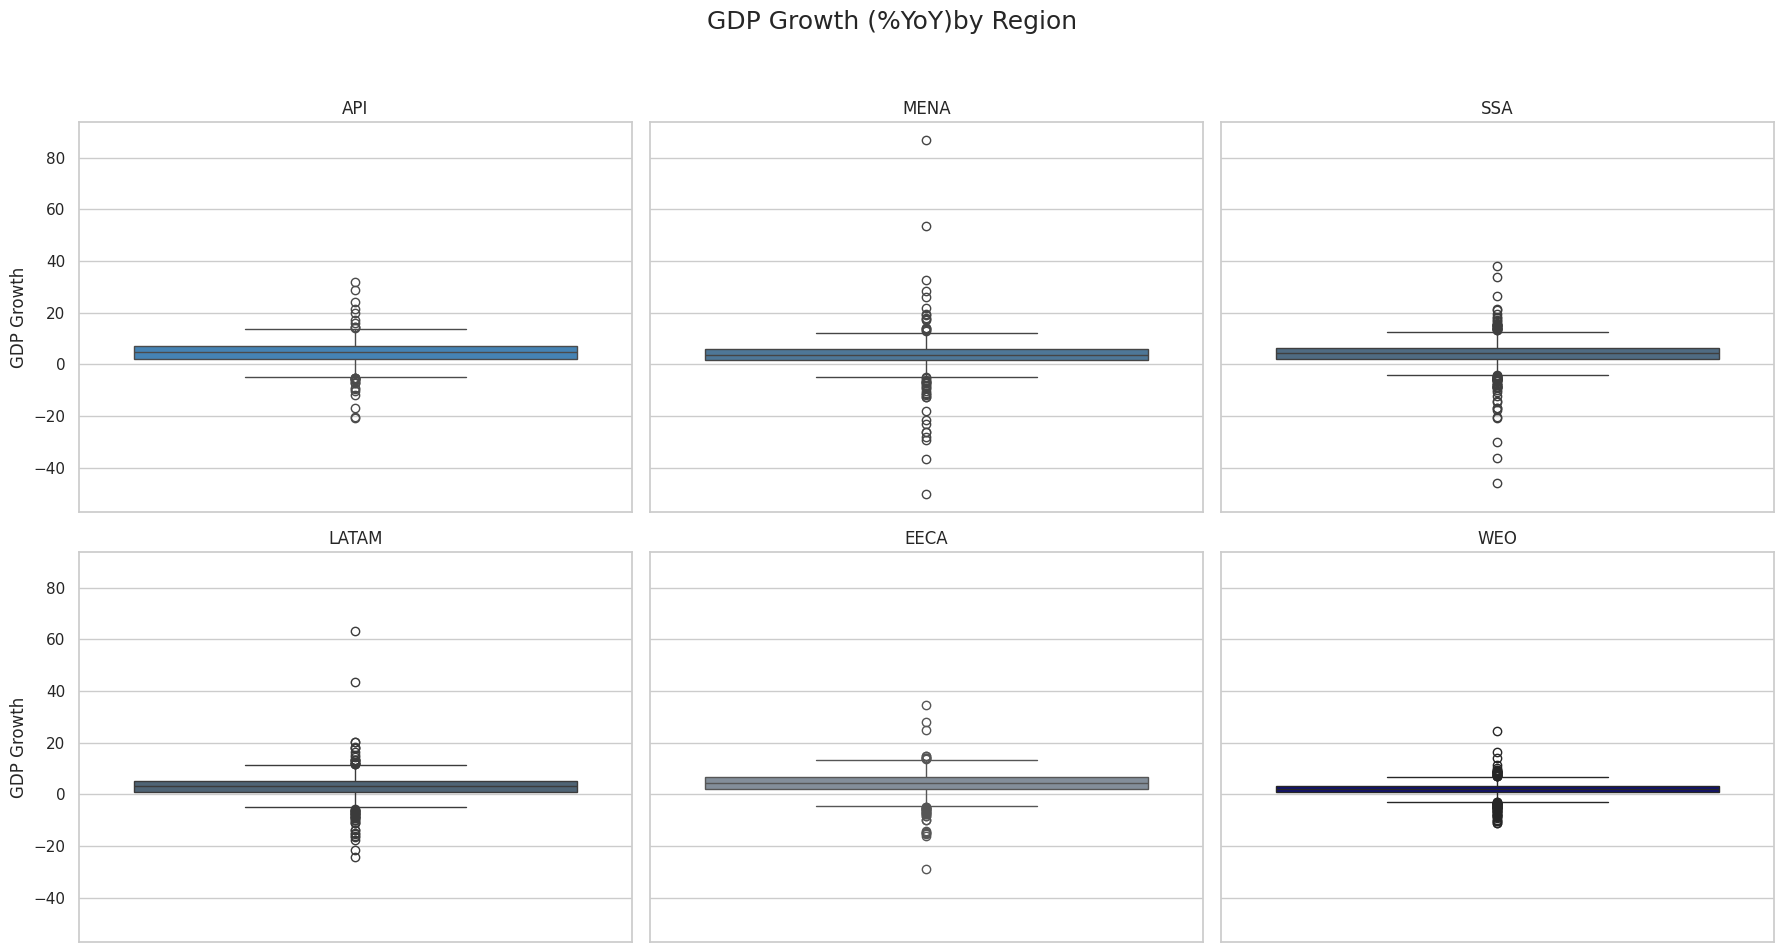

In [ ]:
#boxplots for only gdp growth when subgrouping regional subgroups
regions = ['API', 'MENA', 'SSA', 'LATAM', 'EECA', 'WEO']
colors = ['#3385c6', '#4279a3', '#476c8a', '#49657b', '#7f8e9e', 'navy']
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True)

axes = axes.flatten()
for i, region in enumerate(regions):
    sns.boxplot(
        y=df[df['region'] == region]['gdp_growth'],
        ax=axes[i],
        color=colors[i]
    )
    axes[i].set_title(f'{region}')
    axes[i].set_ylabel('GDP Growth' if i % 3 == 0 else '')
for j in range(len(regions), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('GDP Growth (%YoY)by Region', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


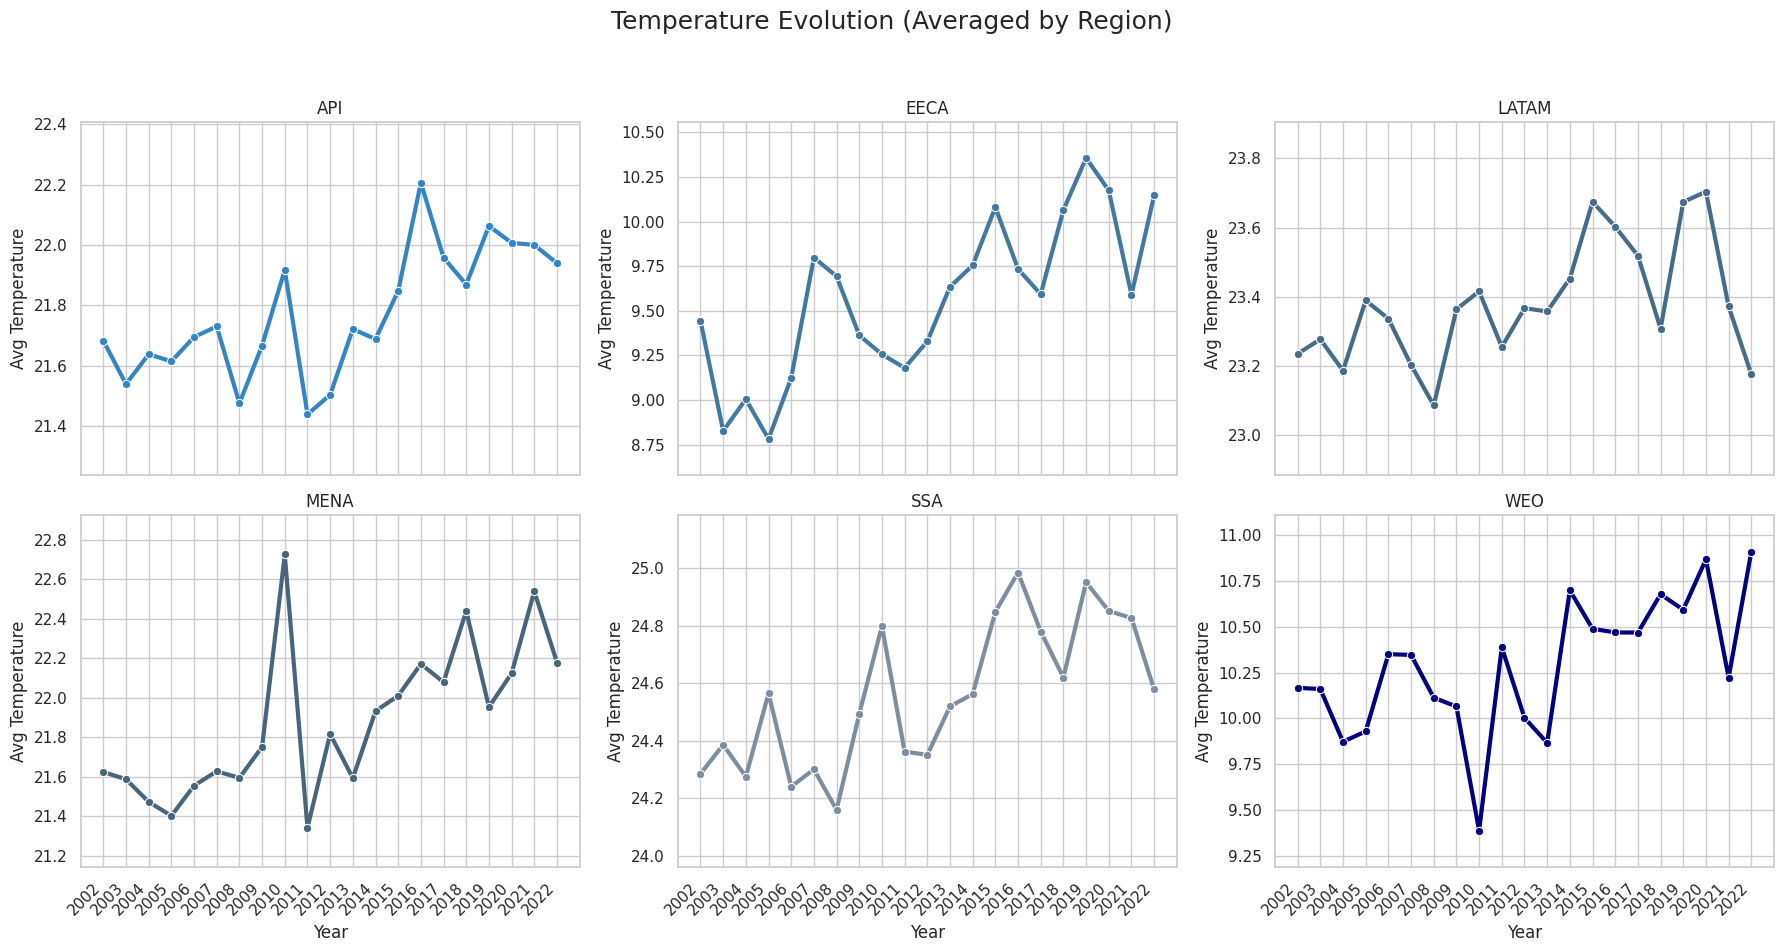

In [ ]:
#evolution of average temperature in each subregion and overall
#group by year and region, then calculate average temperature
avg_temp_by_region_year = df.groupby(['year', 'region'])['temp'].mean().reset_index()
#plot the evolution regions = sorted(avg_temp_by_region_year['region'].unique())
colors = ['#3385c6', '#4279a3', '#476c8a', '#49657b', '#7f8e9e', 'navy']
regions = sorted(avg_temp_by_region_year['region'].unique())

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)
axes = axes.flatten()
for i, region in enumerate(regions):
    regional_data = avg_temp_by_region_year[avg_temp_by_region_year['region'] == region]
    sns.lineplot(
        data=regional_data,
        x='year',
        y='temp',
        marker='o',
        linewidth=3,
        ax=axes[i],
        color=colors[i]
    )
    axes[i].set_title(region)
    axes[i].set_ylabel('Avg Temperature')
    axes[i].set_xlabel('Year')
    plt.setp(axes[i].get_xticklabels(), rotation=45, ha='right')
    y_min = regional_data['temp'].min()
    y_max = regional_data['temp'].max()
    axes[i].set_ylim(y_min - 0.2, y_max + 0.2)
for j in range(len(regions), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Temperature Evolution (Averaged by Region)', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

#### Base Model

In [ ]:
#define regression formula with all fixed effects
formula = "gdp_growth ~ temp + prec + poor:temp + poor:prec + " \
          + "C(country) + C(region_year) + C(poor_year)"

#run regression
model_base = smf.ols(formula, data=df).fit()
results=list()
vars_of_interest = ['temp', 'prec', 'poor:temp', 'poor:prec']
#creating a summary tabel
for var in vars_of_interest:
    coef = model_base.params[var]
    std_err = model_base.bse[var]
    p_value = model_base.pvalues[var]  # Get p-value
    results.append([var, coef, std_err, p_value])
summary_table_base = pd.DataFrame(results, columns=['Variable', 'Coefficient', 'Std. Error','P-Values'])
print(summary_table_base.round(3))

    Variable  Coefficient  Std. Error  P-Values
0       temp        0.085       0.328     0.797
1       prec       -1.195       2.160     0.580
2  poor:temp       -1.292       0.467     0.006
3  poor:prec        4.937       2.816     0.080


#### Adding Lags

In [ ]:
#create a new dataset for the lags
df_lag = df.copy()
df_lag = df_lag.sort_values(by=["country", "year"])

#create lags for temp and prec (2, 5, 10 years)
for lag in [2, 5, 10]:
    df_lag[f"temp_lag{lag}"] = df_lag.groupby("country")["temp"].shift(lag)
    df_lag[f"prec_lag{lag}"] = df_lag.groupby("country")["prec"].shift(lag)
    df_lag[f"poor_temp_lag{lag}"] = df_lag["poor"] * df_lag[f"temp_lag{lag}"]
    df_lag[f"poor_prec_lag{lag}"] = df_lag["poor"] * df_lag[f"prec_lag{lag}"]


In [ ]:
formula_l2 = (
    "gdp_growth ~ "
    "temp + prec + "
    "poor:temp + poor:prec + "
    "temp_lag2 + "
    "prec_lag2 +  "
    "poor_temp_lag2 +"
    "poor_prec_lag2 + "
    "C(country) + C(region_year) + C(poor_year)"
)
formula_l5= (
    "gdp_growth ~ "
    "temp + prec + "
    "poor:temp + poor:prec + "
    "temp_lag5 + "
    "prec_lag5 +  "
    "poor_temp_lag5 +  "
    "poor_prec_lag5 + "
    "C(country) + C(region_year) + C(poor_year)"
)
formula_l10 = (
    "gdp_growth ~ "
    "temp + prec + "
    "poor:temp + poor:prec + "
    "temp_lag10 + "
    "prec_lag10 + "
    "poor_temp_lag10 + "
    "poor_prec_lag10 + "
    "C(country) + C(region_year) + C(poor_year)"
)
formula_all_lag = (
    "gdp_growth ~ "
    "temp + prec + "
    "poor:temp + poor:prec + "
    "temp_lag2 + temp_lag5 + temp_lag10 + "
    "prec_lag2 + prec_lag5 + prec_lag10 + "
    "poor_temp_lag2 + poor_temp_lag5 + poor_temp_lag10 + "
    "poor_prec_lag2 + poor_prec_lag5 + poor_prec_lag10 + "
    "C(country) + C(region_year) + C(poor_year)"
)

model_lag2 = smf.ols(formula_l2, data=df_lag).fit()
model_lag5 = smf.ols(formula_l5, data=df_lag).fit()
model_lag10 = smf.ols(formula_l10, data=df_lag).fit()
#model_all_lags = smf.ols(formula_all_lag, data=df_lag).fit()



#### Adding squared terms

In [ ]:
#adding also quadratic terms
dff=df_lag.copy()
dff["temp_sq"] = dff["temp"] ** 2
dff["prec_sq"] = dff["prec"] ** 2
dff["poor_temp_sq"] = dff["poor"] * dff["temp_sq"]
dff["poor_prec_sq"] = dff["poor"] * dff["prec_sq"]


In [ ]:
formula = (
    "gdp_growth ~ "
    "temp + prec + temp_sq + prec_sq + "
    "poor:temp + poor:prec + poor_temp_sq + poor_prec_sq + "
    "temp_lag2 + temp_lag5 + temp_lag10 + "
    "prec_lag2 + prec_lag5 + prec_lag10 + "
    "poor_temp_lag2 + poor_temp_lag5 + poor_temp_lag10 + "
    "poor_prec_lag2 + poor_prec_lag5 + poor_prec_lag10 + "
    "C(country) + C(region_year) + C(poor_year)"
)

model_all_lags_sq = smf.ols(formula, data=dff).fit()

### Models Comparison

In [ ]:
#studied models
models = {
    "Base": model_base,
    "Lag 2": model_lag2,
    "Lag 5": model_lag5,
    "Lag 10": model_lag10,
    "Final": model_all_lags_sq
}

#variables of interest
vars_of_interest = [
    "temp", "prec", "temp_sq", "prec_sq",  # Original variables
    "poor:temp", "poor:prec", "poor_temp_sq", "poor_prec_sq",  # Interaction terms
    "temp_lag2", "temp_lag5", "temp_lag10",  # Lags of temperature
    "prec_lag2", "prec_lag5", "prec_lag10",  # Lags of precipitation
    "poor_temp_lag2", "poor_temp_lag5", "poor_temp_lag10",  # Lagged interactions
    "poor_prec_lag2", "poor_prec_lag5", "poor_prec_lag10"  # Lagged interactions with precipitation
]

#function to assign star based on p-value
def get_stars(pval):
    if pval < 0.01:
        return "***"
    elif pval < 0.05:
        return "**"
    elif pval < 0.10:
        return "*"
    else:
        return ""


results = []

for name, model in models.items():
    for var in vars_of_interest:
        if var in model.params.index:
            coef = model.params[var]
            pval = model.pvalues[var]
            stars = get_stars(pval)  # Get stars based on p-value
        else:
            coef = None
            stars = None

        results.append({
            "Model": name,
            "Variable": var,
            "Coefficient": coef,
            "Stars": stars
        })

#convert to DataFrame and pivot for easier comparison
results_df = pd.DataFrame(results)
pivot_df = results_df.pivot(index="Variable", columns="Model", values="Coefficient")
pivot_stars = results_df.pivot(index="Variable", columns="Model", values="Stars")

#combine into a single display table
combined = pivot_df.round(3).astype(str) + pivot_stars
#display the main results table
combined

Model,Base,Final,Lag 10,Lag 2,Lag 5
Variable,,,,,
poor:prec,4.937*,3.95,4.031,4.105,4.213
poor:temp,-1.292***,-3.05**,-0.447,-1.209**,-0.955*
poor_prec_lag10,NaN,2.97,3.382,NaN,NaN
poor_prec_lag2,NaN,1.132,NaN,-0.523,NaN
poor_prec_lag5,NaN,-4.595,NaN,NaN,-1.663
poor_prec_sq,NaN,0.252,NaN,NaN,NaN
poor_temp_lag10,NaN,0.414,0.534,NaN,NaN
poor_temp_lag2,NaN,-1.047,NaN,-1.126**,NaN
poor_temp_lag5,NaN,0.093,NaN,NaN,-0.313


In [ ]:
pval_results = []

for name, model in models.items():
    for var in vars_of_interest:
        if var in model.pvalues.index:
            pval = model.pvalues[var]
        else:
            pval = None
        pval_results.append({
            "Model": name,
            "Variable": var,
            "PValue": pval
        })

# Create DataFrame and pivot
pval_df = pd.DataFrame(pval_results)
pivot_pvals = pval_df.pivot(index="Variable", columns="Model", values="PValue")

#round to third deciaml number and display teh table
pivot_pvals = pivot_pvals.round(3)
pivot_pvals

Model,Base,Final,Lag 10,Lag 2,Lag 5
Variable,,,,,
poor:prec,0.080,0.699,0.341,0.162,0.186
poor:temp,0.006,0.025,0.523,0.011,0.067
poor_prec_lag10,NaN,0.473,0.400,NaN,NaN
poor_prec_lag2,NaN,0.779,NaN,0.860,NaN
poor_prec_lag5,NaN,0.261,NaN,NaN,0.607
poor_prec_sq,NaN,0.973,NaN,NaN,NaN
poor_temp_lag10,NaN,0.534,0.417,NaN,NaN
poor_temp_lag2,NaN,0.105,NaN,0.021,NaN
poor_temp_lag5,NaN,0.890,NaN,NaN,0.563


In [ ]:
#variables to extract from models dictionary
vars_to_extract = ['poor:temp', 'poor_temp_lag2', 'poor_temp_lag5', 'poor_temp_lag10', 'poor_temp_sq']
results = []
#looping to get all the info needed
for name, model in models.items():
    row = {'Model': name}  # Start with the model name
    for var in vars_to_extract:
        if var in model.params.index:
            row[f'{var}_coef'] = model.params[var]
            row[f'{var}_pval'] = model.pvalues[var]
        else:
            row[f'{var}_coef'] = None
            row[f'{var}_pval'] = None
    results.append(row)
#converting into a pd dataframe for facility of operation
poor_temp_eff_table = pd.DataFrame(results)
#fillng NaN vlaues with 0
poor_temp_eff_table = poor_temp_eff_table.fillna(0)
#calcualte the toal effect as the summation of all teh coefficients relative to poor:temp
coef_cols = [col for col in poor_temp_eff_table.columns if 'coef' in col]
poor_temp_eff_table['poor:temp_coef_total'] = poor_temp_eff_table[coef_cols].sum(axis=1)
poor_temp_eff_table

,Model,poor:temp_coef,poor:temp_pval,poor_temp_lag2_coef,poor_temp_lag2_pval,poor_temp_lag5_coef,poor_temp_lag5_pval,poor_temp_lag10_coef,poor_temp_lag10_pval,poor_temp_sq_coef,poor_temp_sq_pval,poor:temp_coef_total
0,Base,-1.291942,0.005710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.291942
1,Lag 2,-1.209057,0.010816,-1.126079,0.020925,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.335136
2,Lag 5,-0.955190,0.066639,0.000000,0.000000,-0.312543,0.563473,0.000000,0.000000,0.000000,0.000000,-1.267733
3,Lag 10,-0.446998,0.522697,0.000000,0.000000,0.000000,0.000000,0.534402,0.417254,0.000000,0.000000,0.087405
4,Final,-3.050418,0.025218,-1.046994,0.104942,0.093228,0.889709,0.413910,0.533669,0.091959,0.022672,-3.498315


Base model only

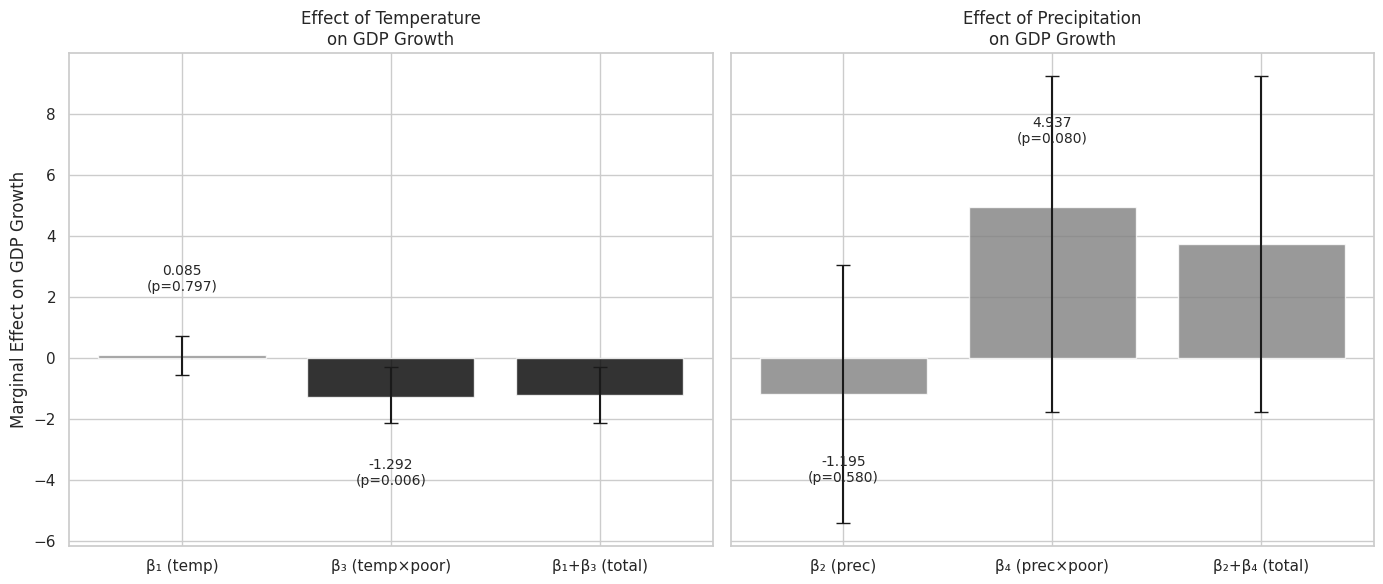

In [ ]:
# === Helper functions ===
def get_color(lower, upper):
    return 'black' if (lower > 0 or upper < 0) else 'gray'

def add_label(ax, x, y, pval):
    label = f'{y:.3f}\n(p={pval:.3f})'
    ax.text(x, y + 2 if y >= 0 else y - 2, label,
            ha='center', va='bottom' if y >= 0 else 'top', fontsize=10)

# === Coefficients and p-values ===
coefficients = model_base.params
conf_int = model_base.conf_int()
pvalues = model_base.pvalues

# Extract main and interaction effects
temp_coeff = coefficients['temp']
prec_coeff = coefficients['prec']
poor_temp_coeff = coefficients['poor:temp']
poor_prec_coeff = coefficients['poor:prec']

# Confidence intervals
temp_ci = conf_int.loc['temp']
prec_ci = conf_int.loc['prec']
poor_temp_ci = conf_int.loc['poor:temp']
poor_prec_ci = conf_int.loc['poor:prec']

# Effects
temp_rich_effect = temp_coeff
temp_poor_effect = poor_temp_coeff
temp_total_effect = temp_coeff + poor_temp_coeff

prec_rich_effect = prec_coeff
prec_poor_effect = poor_prec_coeff
prec_total_effect = prec_coeff + poor_prec_coeff

# CIs for rich
temp_rich_ci_lower, temp_rich_ci_upper = temp_ci
prec_rich_ci_lower, prec_rich_ci_upper = prec_ci

# CIs for poor
temp_poor_ci_lower = poor_temp_ci[0] + temp_coeff
temp_poor_ci_upper = poor_temp_ci[1] + temp_coeff
prec_poor_ci_lower = poor_prec_ci[0] + prec_coeff
prec_poor_ci_upper = poor_prec_ci[1] + prec_coeff

# Colors
color_temp_rich = get_color(temp_rich_ci_lower, temp_rich_ci_upper)
color_temp_poor = get_color(temp_poor_ci_lower, temp_poor_ci_upper)
color_temp_total = get_color(temp_poor_ci_lower, temp_poor_ci_upper)

color_prec_rich = get_color(prec_rich_ci_lower, prec_rich_ci_upper)
color_prec_poor = get_color(prec_poor_ci_lower, prec_poor_ci_upper)
color_prec_total = get_color(prec_poor_ci_lower, prec_poor_ci_upper)

# === Plot ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Temperature subplot
labels_temp = ['β₁ (temp)', 'β₃ (temp×poor)', 'β₁+β₃ (total)']
effects_temp = [temp_rich_effect, temp_poor_effect, temp_total_effect]
errors_temp = [
    [temp_rich_effect - temp_rich_ci_lower, temp_rich_ci_upper - temp_rich_effect],
    [temp_poor_effect - temp_poor_ci_lower, temp_poor_ci_upper - temp_poor_effect],
    [temp_total_effect - (poor_temp_ci[0] + temp_coeff), (poor_temp_ci[1] + temp_coeff) - temp_total_effect]
]
colors_temp = [color_temp_rich, color_temp_poor, color_temp_total]
pvals_temp = [pvalues['temp'], pvalues['poor:temp'], None]  # Total effect p-value is not directly available

for i, (label, effect, err, color, pval) in enumerate(zip(labels_temp, effects_temp, errors_temp, colors_temp, pvals_temp)):
    bar = axes[0].bar(label, effect, yerr=[[err[0]], [err[1]]],
                      capsize=5, color=color, alpha=0.8)
    if pval is not None:
        add_label(axes[0], label, effect, pval)

axes[0].set_title('Effect of Temperature\non GDP Growth')
axes[0].set_ylabel('Marginal Effect on GDP Growth')

# Precipitation subplot
labels_prec = ['β₂ (prec)', 'β₄ (prec×poor)', 'β₂+β₄ (total)']
effects_prec = [prec_rich_effect, prec_poor_effect, prec_total_effect]
errors_prec = [
    [prec_rich_effect - prec_rich_ci_lower, prec_rich_ci_upper - prec_rich_effect],
    [prec_poor_effect - prec_poor_ci_lower, prec_poor_ci_upper - prec_poor_effect],
    [prec_total_effect - (poor_prec_ci[0] + prec_coeff), (poor_prec_ci[1] + prec_coeff) - prec_total_effect]
]
colors_prec = [color_prec_rich, color_prec_poor, color_prec_total]
pvals_prec = [pvalues['prec'], pvalues['poor:prec'], None]

for i, (label, effect, err, color, pval) in enumerate(zip(labels_prec, effects_prec, errors_prec, colors_prec, pvals_prec)):
    bar = axes[1].bar(label, effect, yerr=[[err[0]], [err[1]]],
                      capsize=5, color=color, alpha=0.8)
    if pval is not None:
        add_label(axes[1], label, effect, pval)

axes[1].set_title('Effect of Precipitation\non GDP Growth')

plt.tight_layout()
plt.show()


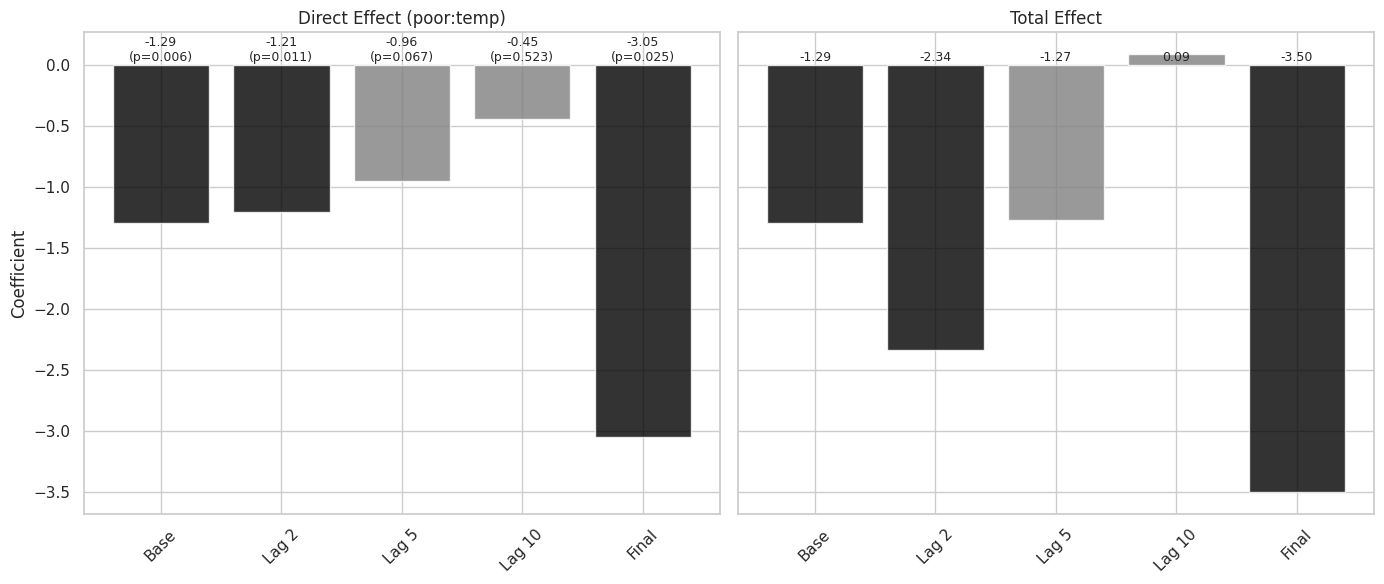

In [ ]:
df_effects = poor_temp_eff_table

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Define bar colors based on p-value for both charts
colors = ['black' if p < 0.05 else 'gray' for p in df_effects['poor:temp_pval']]

# Plot 1: Direct effect (poor:temp_coef)
axes[0].bar(df_effects['Model'], df_effects['poor:temp_coef'], color=colors,alpha = 0.8)
axes[0].set_title('Direct Effect (poor:temp)')
axes[0].set_ylabel('Coefficient')
axes[0].tick_params(axis='x', rotation=45)

# Annotate coefficients and p-values under bars for plot 1
for i, (coef, pval) in enumerate(zip(df_effects['poor:temp_coef'], df_effects['poor:temp_pval'])):
    axes[0].text(i, 0.01, f"{coef:.2f}\n(p={pval:.3f})", ha='center', va='bottom', fontsize=9, rotation=0)

# Plot 2: Total effect (poor_temp_coef_total) with same colors
axes[1].bar(df_effects['Model'], df_effects['poor:temp_coef_total'], color=colors,alpha = 0.8)
axes[1].set_title('Total Effect')
axes[1].tick_params(axis='x', rotation=45)

# Annotate total effect coefficients under bars for plot 2
for i, coef in enumerate(df_effects['poor:temp_coef_total']):
    axes[1].text(i, 0.01, f"{coef:.2f}", ha='center', va='bottom', fontsize=9, rotation=0)

plt.tight_layout()
plt.show()


Lagged Models

### Region Heterogeneity Analysis

In [ ]:
#verify the unicity of the regions
dff.region.unique()
#reordering and categorizing to use WEO as the base region
dff['region'] = pd.Categorical(df['region'], categories=['WEO', 'API', 'EECA', 'MENA', 'SSA', 'LATAM'], ordered=False)

In [ ]:
from patsy.contrasts import Treatment
#creating a new frmula with all subregions interaction terms
formula_subr = (
    "gdp_growth ~ "
    "temp + prec + temp_sq + prec_sq + "
    "C(region):temp + C(region):prec + "
    "poor:temp + poor:prec + poor_temp_sq + poor_prec_sq + "
    "temp_lag2 + temp_lag5 + temp_lag10 + "
    "prec_lag2 + prec_lag5 + prec_lag10 + "
    "poor_temp_lag2 + poor_temp_lag5 + poor_temp_lag10 + "
    "poor_prec_lag2 + poor_prec_lag5 + poor_prec_lag10 + "
    "C(country) + C(region_year) + C(poor_year)"
)
contrast = {'region': Treatment(reference='WEO')}
model_subr = smf.ols(formula_subr, data=dff).fit()

In [ ]:
model_subr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             gdp_growth   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.333
Method:                 Least Squares   F-statistic:                     4.507
Date:                Sun, 04 May 2025   Prob (F-statistic):           5.00e-83
Time:                        12:54:55   Log-Likelihood:                -5578.1
No. Observations:                1944   AIC:                         1.171e+04
Df Residuals:                    1666   BIC:                         1.326e+04
Df Model:                         277                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                       33.9127     15.680      2.163      0.031       3.159      64.667
C(country)[T.Albania]                           -4.8814      7.053     -0.692      0.489     -18.715       8.952
C(country)[T.Algeria]                           22.8116      7.567      3.014      0.003       7.969      37.654
C(country)[T.Andorra]                          -10.0188      7.068     -1.418      0.157     -23.881       3.844
C(country)[T.Angola]                             0.2128      3.550      0.060      0.952      -6.751       7.177
C(country)[T.Argentina]                        -13.6818      7.506     -1.823      0.069     -28.404       1.041
C(country)[T.Armenia]                           -7.0056      7.134     -0.982      0.326     -20.998       6.987
C(country)[T.Australia]                         -1.3263     13.080     -0.101      0.919     -26.982      24.329
C(country)[T.Austria]                           -9.8182      5.735     -1.712      0.087     -21.066       1.430
C(country)[T.Azerbaijan]                        -4.3000      5.800     -0.741      0.459     -15.676       7.076
C(country)[T.Bahamas, The]                      -4.7327     11.582     -0.409      0.683     -27.449      17.983
C(country)[T.Bahrain]                           43.1814     15.537      2.779      0.006      12.707      73.656
C(country)[T.Bangladesh]                        37.8783     23.385      1.620      0.105      -7.988      83.745
C(country)[T.Barbados]                          -4.4720     12.971     -0.345      0.730     -29.914      20.970
C(country)[T.Belarus]                          -11.1079      7.088     -1.567      0.117     -25.009       2.794
C(country)[T.Belgium]                           -8.0617      4.753     -1.696      0.090     -17.384       1.261
C(country)[T.Belize]                            -3.1154     12.192     -0.256      0.798     -27.028      20.797
C(country)[T.Benin]                              8.1559      8.844      0.922      0.357      -9.190      25.502
C(country)[T.Bhutan]                             4.2867      6.864      0.625      0.532      -9.177      17.750
C(country)[T.Bolivia]                            2.5670      7.199      0.357      0.721     -11.552      16.686
C(country)[T.Bosnia and Herzegovina]            -6.7186      5.922     -1.135      0.257     -18.334       4.896
C(country)[T.Botswana]                         -12.7049     12.711     -0.999      0.318     -37.637      12.227
C(country)[T.Brazil]                            -6.5285     10.141     -0.644      0.520     -26.419      13.362
C(country)[T.Brunei Darussalam]                 26.4720     22.292      1.188      0.235     -17.252      70.196
C(country)[T.Bulgaria]          

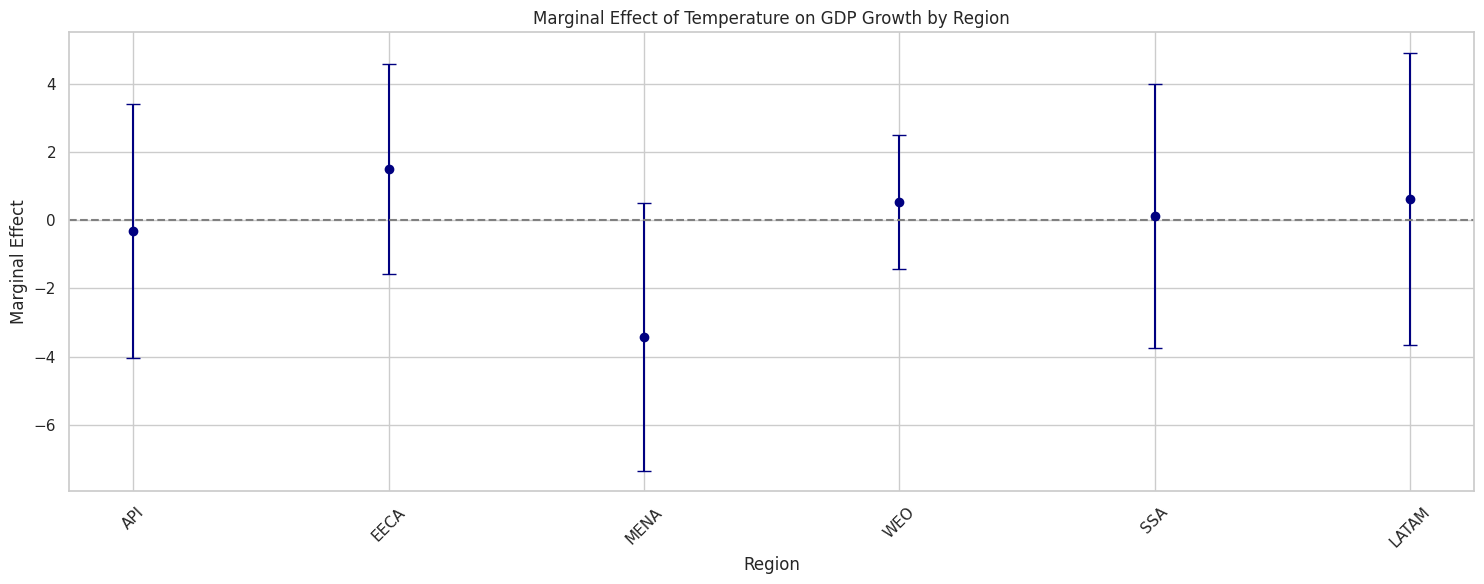

In [ ]:
# plotting the marginal effect of temp on different subregions
base_temp_coef = model_subr.params.get('temp', 0)

regions = df['region'].unique()
marginal_effects = []
ci_lower = []
ci_upper = []

for region in regions:
    # build interaction term name
    interaction_term = f'C(region)[T.{region}]:temp'

    # interaction coefficient (0 if it's the base region)
    interaction_coef = model_subr.params.get(interaction_term, 0)

    total_effect = base_temp_coef + interaction_coef
    marginal_effects.append(total_effect)
#    marginal_effects.append(interaction_coeff)  #HERE USED THIS FOR THE SECOND PLOT


    # Confidence intervals
    base_se = model_subr.bse.get('temp', 0)
    interaction_se = model_subr.bse.get(interaction_term, 0)

    # assume independence (ignore covariances)
    se_total = (base_se**2 + interaction_se**2)**0.5
    lower = total_effect - 1.96 * se_total
    upper = total_effect + 1.96 * se_total

    ci_lower.append(lower)
    ci_upper.append(upper)

# plotting the results
plt.figure(figsize=(15, 6))
plt.errorbar(regions, marginal_effects,
             yerr=[pd.Series(marginal_effects) - pd.Series(ci_lower),
                   pd.Series(ci_upper) - pd.Series(marginal_effects)],
             fmt='o', capsize=5, color='navy')
plt.axhline(0, linestyle='--', color='gray')
plt.title('Marginal Effect of Temperature on GDP Growth by Region')
plt.ylabel('Marginal Effect')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


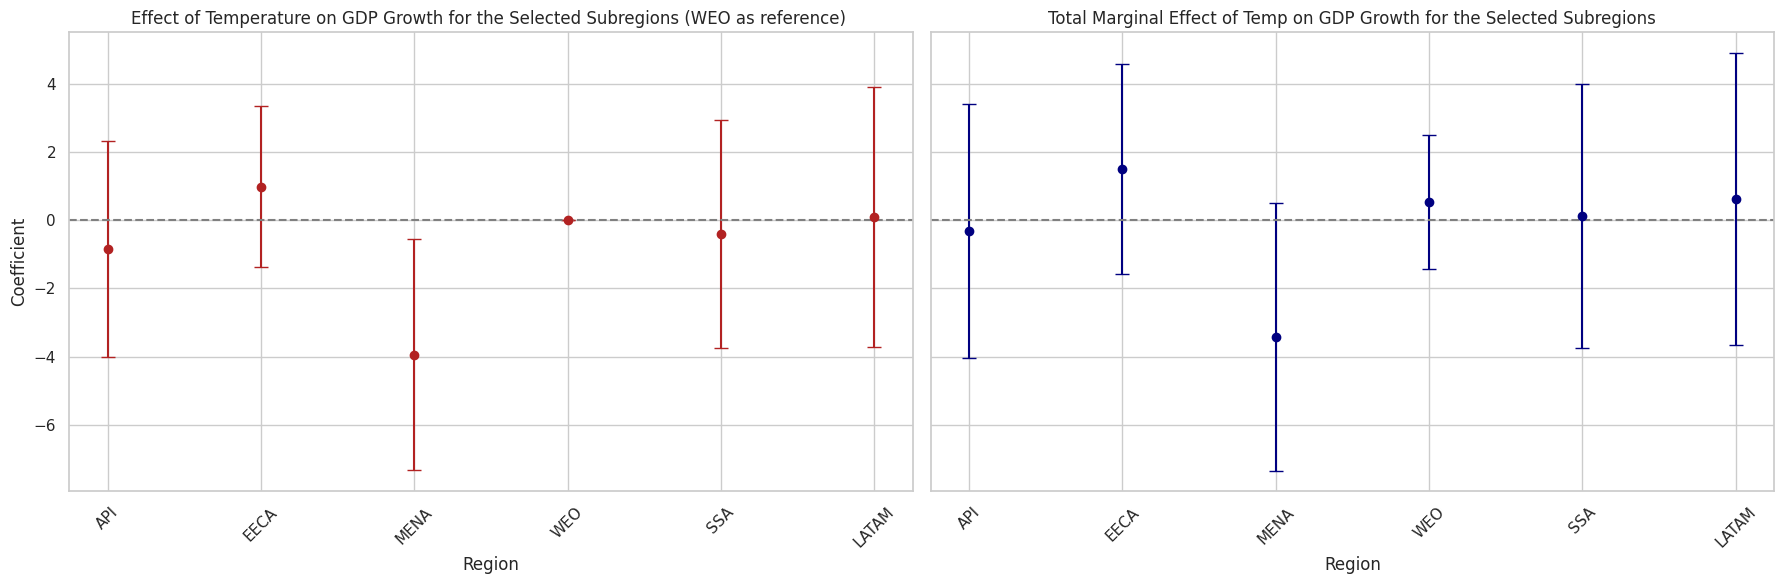

In [ ]:
# base temperature coefficient
base_temp_coef = model_subr.params.get('temp', 0)

regions = df['region'].unique()
interaction_coeffs = []
marginal_effects = []
ci_lower_inter = []
ci_upper_inter = []
ci_lower_total = []
ci_upper_total = []

for region in regions:
    # build interaction term name
    interaction_term = f'C(region)[T.{region}]:temp'

    # get coefficients
    interaction_coef = model_subr.params.get(interaction_term, 0)
    total_effect = base_temp_coef + interaction_coef

    interaction_coeffs.append(interaction_coef)
    marginal_effects.append(total_effect)

    # standard errors
    base_se = model_subr.bse.get('temp', 0)
    interaction_se = model_subr.bse.get(interaction_term, 0)

    # assume independence
    se_total = (base_se**2 + interaction_se**2)**0.5

    # CI for interaction only
    ci_lower_inter.append(interaction_coef - 1.96 * interaction_se)
    ci_upper_inter.append(interaction_coef + 1.96 * interaction_se)

    # CI for total effect
    ci_lower_total.append(total_effect - 1.96 * se_total)
    ci_upper_total.append(total_effect + 1.96 * se_total)

# plotting
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# LEFT: Interaction Coefficients
axes[0].errorbar(regions, interaction_coeffs,
                 yerr=[pd.Series(interaction_coeffs) - pd.Series(ci_lower_inter),
                       pd.Series(ci_upper_inter) - pd.Series(interaction_coeffs)],
                 fmt='o', capsize=5, color='firebrick')
axes[0].axhline(0, linestyle='--', color='gray')
axes[0].set_title('Effect of Temperature on GDP Growth for the Selected Subregions (WEO as reference) ')
axes[0].set_ylabel('Coefficient')
axes[0].set_xlabel('Region')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

# RIGHT: Total Marginal Effects
axes[1].errorbar(regions, marginal_effects,
                 yerr=[pd.Series(marginal_effects) - pd.Series(ci_lower_total),
                       pd.Series(ci_upper_total) - pd.Series(marginal_effects)],
                 fmt='o', capsize=5, color='navy')
axes[1].axhline(0, linestyle='--', color='gray')
axes[1].set_title('Total Marginal Effect of Temp on GDP Growth for the Selected Subregions')
axes[1].set_xlabel('Region')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [ ]:
unique_countries = df['country'].unique()
unique_regions = df['poor'].unique()

# To get unique combinations of 'country' and 'region':
unique_combinations = df[['country', 'poor']].drop_duplicates()

In [ ]:
!pip install openpyxl

import pandas as pd
import openpyxl  # Or xlsxwriter


# ... (your existing code to create unique_combinations DataFrame) ...

# Export to Excel
unique_combinations.to_excel('unique_country_region_combinations.xlsx', index=False)